In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import scipy.optimize as sco
sns.set()

### ETF Price Download

In [2]:
tickers = ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
etf = yf.Tickers(tickers)
data = etf.history(start= '2011-01-01', actions=False)
data.drop(['Open','High','Low','Volume'], inplace=True, axis=1)
data = data.droplevel(0, axis=1)

[*********************100%***********************]  9 of 9 completed


In [3]:
rets = data.pct_change().fillna(0)
er = rets.mean() * 252
cov = rets.cov() *252


In [4]:
cov

Ticker,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
Ticker,,,,,,,,,
XLB,0.042813,0.041617,0.037685,0.035554,0.032283,0.018853,0.019343,0.024013,0.031583
XLE,0.041617,0.077772,0.043248,0.038527,0.030594,0.018054,0.019328,0.023713,0.030454
XLF,0.037685,0.043248,0.048326,0.037386,0.033146,0.019957,0.019750,0.025701,0.033312
XLI,0.035554,0.038527,0.037386,0.037448,0.031714,0.018746,0.019098,0.023599,0.031221
XLK,0.032283,0.030594,0.033146,0.031714,0.046138,0.018774,0.017344,0.025142,0.036646
XLP,0.018853,0.018054,0.019957,0.018746,0.018774,0.019319,0.017551,0.016606,0.017876
XLU,0.019343,0.019328,0.019750,0.019098,0.017344,0.017551,0.031665,0.016544,0.016686
XLV,0.024013,0.023713,0.025701,0.023599,0.025142,0.016606,0.016544,0.026478,0.022873
XLY,0.031583,0.030454,0.033312,0.031221,0.036646,0.017876,0.016686,0.022873,0.040089


In [6]:
rets

Ticker,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
Date,,,,,,,,,
2011-01-03 00:00:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-04 00:00:00+00:00,-0.006715,-0.008581,-0.001227,-0.001423,0.003926,-0.002725,0.004764,0.003146,-0.005548
2011-01-05 00:00:00+00:00,0.002341,0.003961,0.011671,0.005133,0.005867,0.000341,-0.006321,0.002195,0.008236
2011-01-06 00:00:00+00:00,-0.005188,-0.009497,-0.006679,-0.001702,0.005832,-0.003415,0.000954,0.004068,-0.006060
2011-01-07 00:00:00+00:00,-0.001043,0.007228,-0.008558,0.001989,-0.004639,-0.005141,0.003495,-0.000623,-0.000531
...,...,...,...,...,...,...,...,...,...
2024-08-27 00:00:00+00:00,0.000107,-0.009320,0.005160,0.000619,0.006059,0.002427,-0.007904,0.001545,-0.002629
2024-08-28 00:00:00+00:00,-0.004294,-0.006420,0.002455,-0.000464,-0.013798,-0.004236,0.000000,0.001157,-0.009682
2024-08-29 00:00:00+00:00,0.005499,0.013033,0.008907,0.007046,-0.009024,-0.004984,0.005444,0.002118,0.001195


### Maximum Sharpe

In [8]:
def get_msr_weights(er,cov):
    noa = er.shape[0]
    init_guess = np.repeat(1/noa, noa)
    bounds = ((0.0,1.0),) * noa # make 0~1사이 값을 noa개 생성
    # no leverage const 
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights : np.sum(weights)-1}  # sum of the weight should be 1

# objective function  : scipy minimize 사용할거니까 negative
    def neg_sharpe(weights,er,cov):
        r = weights.T @ er
        vol = np.sqrt(weights.T @ cov @ weights)
        return - r/vol

#optimization 
    res = sco.minimize(neg_sharpe,
                       init_guess,
                       args=(er, cov),
                       method='SLSQP',
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return res.x

In [9]:
msr_weights = get_msr_weights(er, cov)
msr_weights

array([0.00000000e+00, 4.41117683e-17, 0.00000000e+00, 8.40587880e-17,
       3.50947139e-01, 1.74946127e-01, 8.52324812e-02, 3.88874252e-01,
       0.00000000e+00])

In [10]:
msr_ret = np.dot(msr_weights, er)
msr_ret

0.15448884696197918

In [11]:
msr_vol = np.sqrt(np.dot(msr_weights.T, np.dot(cov, msr_weights)))
msr_vol

0.15682073866466217

In [12]:
print('Return = {}'.format(msr_ret))
print('Volatility = {}'.format(msr_vol))

Return = 0.15448884696197918
Volatility = 0.15682073866466217


<Axes: >

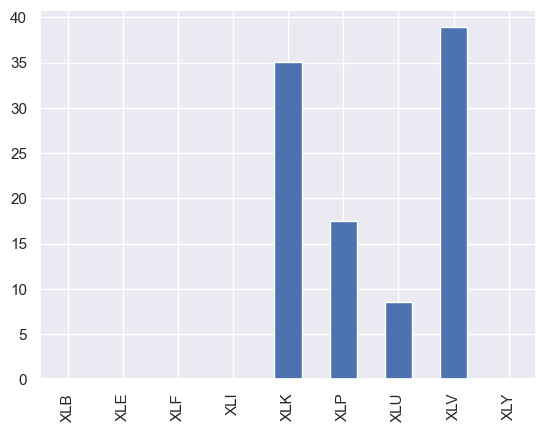

In [13]:
msr_weights_series = pd.Series(np.round(msr_weights, 4) * 100, index=tickers)
msr_weights_series.plot.bar()

### Capital Market Line

In [15]:
# PF's stat
def statistics(weights):
    weights = np.array(weights)
    pret = np.sum(er * weights)
    pvol = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
    return np.array([pret, pvol, pret/pvol])

# objective function : 
def obj_func(weights):
    return statistics(weights)[1]  # pvol

In [16]:
noa = len(tickers)

trets = np.linspace(0.1, 0.15, 50) # 0.10~0.15 까지 균등 분할
tvols = []

for tret in trets:


    init_guess = np.repeat(1/noa, noa) # array([0.11111111, 0.11111111, 0.11111111....)

    # const = 1. pret = tret 2. weight sum = 1
    cons = ({'type': 'eq', 'fun': lambda x: statistics(x)[0] - tret},
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    
    bnds = ((0.0, 1.0), ) * noa

    res = sco.minimize(obj_func,
                       init_guess,
                       method='SLSQP',
                       bounds=bnds,
                       constraints=cons)

    tvols.append(res['fun'])

tvols = np.array(tvols)

In [26]:
init_guess

array([0.11111111, 0.11111111, 0.11111111, 0.11111111, 0.11111111,
       0.11111111, 0.11111111, 0.11111111, 0.11111111])

In [18]:
tvols

array([0.19933274, 0.19085602, 0.18278461, 0.17517455, 0.16808851,
       0.16159545, 0.15576953, 0.15068815, 0.14642884, 0.14304235,
       0.14052366, 0.13891551, 0.13820961, 0.13777999, 0.13740693,
       0.13709101, 0.13683363, 0.1366324 , 0.13649095, 0.13642009,
       0.13642904, 0.13651706, 0.13667444, 0.13688899, 0.1371282 ,
       0.13739493, 0.137695  , 0.13802536, 0.13838638, 0.13877775,
       0.13919916, 0.13965031, 0.14013099, 0.14064086, 0.14117962,
       0.14174691, 0.1423428 , 0.1429659 , 0.14361658, 0.14429451,
       0.14499919, 0.14574155, 0.14649611, 0.14727659, 0.14808284,
       0.14891412, 0.14977022, 0.15064867, 0.1515522 , 0.15247893])

In [17]:
ind = np.argmin(tvols) # indicator, min tvols 20th
evols = tvols[ind:]
erets = trets[ind:]

In [19]:
ind

19

In [20]:
evols

array([0.13642009, 0.13642904, 0.13651706, 0.13667444, 0.13688899,
       0.1371282 , 0.13739493, 0.137695  , 0.13802536, 0.13838638,
       0.13877775, 0.13919916, 0.13965031, 0.14013099, 0.14064086,
       0.14117962, 0.14174691, 0.1423428 , 0.1429659 , 0.14361658,
       0.14429451, 0.14499919, 0.14574155, 0.14649611, 0.14727659,
       0.14808284, 0.14891412, 0.14977022, 0.15064867, 0.1515522 ,
       0.15247893])

In [21]:
erets

array([0.11938776, 0.12040816, 0.12142857, 0.12244898, 0.12346939,
       0.1244898 , 0.1255102 , 0.12653061, 0.12755102, 0.12857143,
       0.12959184, 0.13061224, 0.13163265, 0.13265306, 0.13367347,
       0.13469388, 0.13571429, 0.13673469, 0.1377551 , 0.13877551,
       0.13979592, 0.14081633, 0.14183673, 0.14285714, 0.14387755,
       0.14489796, 0.14591837, 0.14693878, 0.14795918, 0.14897959,
       0.15      ])

In [22]:
evols[-1]

0.15247892765553647

Text(0.5, 1.0, 'Market Portfolio & Capital Market Line')

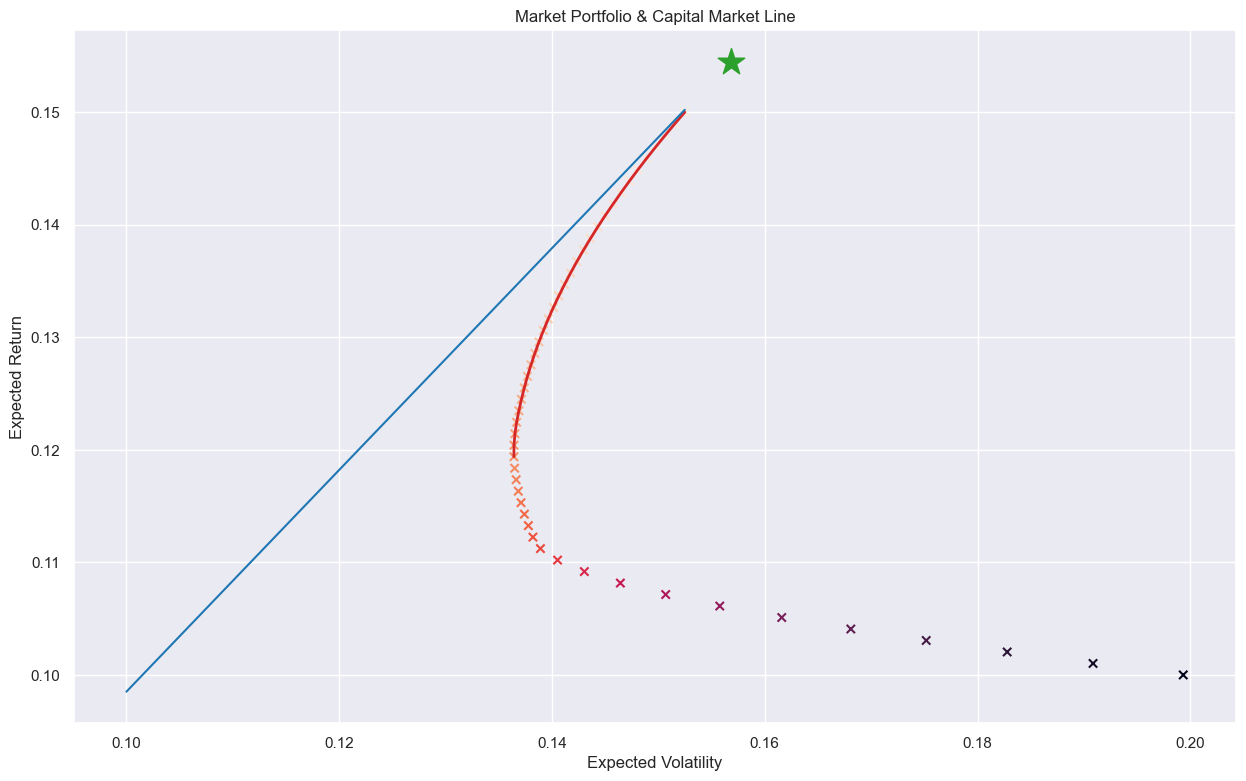

In [33]:
# 자본시장선 데이터
x = np.linspace(0.1, evols[-1], 100)
y = (msr_ret / msr_vol) * x # 기울기 곱하기 x , 이게 자본시장선 

# 효율적 경계선 및 자본시장선 시각화
plt.figure(figsize=(15, 9))

plt.scatter(tvols, trets, c=trets/tvols, marker='x')
plt.plot(evols, erets, 'tab:red', lw=2.0)

# 시장 포트폴리오
plt.scatter(msr_vol, msr_ret, marker='*', s=400, color='tab:green')

# 자본시장선
plt.plot(x, y, 'tab:blue')

plt.grid(True)

plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')

plt.title('Market Portfolio & Capital Market Line')
